In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')

import re
from itertools import chain
import string
from collections import Counter

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Functions
def remove_punctuation(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words]
    
    # Join the words back into a single string
    clean_text = ' '.join(words)
    
    return clean_text

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

def stem_words(words):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

In [3]:
emotions_df = pd.read_csv("/kaggle/input/emotions/text.csv")
emotions_df.drop(['Unnamed: 0'],axis=1,inplace = True)

In [4]:
emotions_df.shape

(416809, 2)

In [5]:
emotions_df.isna().sum()

text     0
label    0
dtype: int64

In [6]:
sum(emotions_df[['text',"label"]].duplicated())

686

In [7]:
emotions_df = emotions_df[~emotions_df[['text',"label"]].duplicated()]

In [8]:
emotions_df.shape

(416123, 2)

In [9]:
emotions_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [10]:
emotions_df['cleaned_text'] = emotions_df.text.apply(lambda x:remove_punctuation(x))
emotions_df['cleaned_text'] = emotions_df.cleaned_text.apply(lambda x: x.lower())
emotions_df['msg_tokenied']= emotions_df.cleaned_text.apply(lambda x: word_tokenize(x))
emotions_df['msg_tokenied_wo_stopwords']= emotions_df['msg_tokenied'].apply(lambda x:remove_stopwords(x))

In [11]:
emotions_df['msg_tokenied_wo_stopwords_stemmed'] = emotions_df['msg_tokenied_wo_stopwords'].apply(lambda x: stem_words(x))

In [12]:
emotions_df["word_count"] = emotions_df.msg_tokenied_wo_stopwords_stemmed.apply(len)

In [13]:
label_mapping = {0:'Sadness', 1:'Joy', 2:'Love', 3:'Anger', 4:'Fear', 5:'Surprise'}
emotions_df['label'] = emotions_df['label'].replace(label_mapping)

In [14]:
emotions_df.head()

,text,label,cleaned_text,msg_tokenied,msg_tokenied_wo_stopwords,msg_tokenied_wo_stopwords_stemmed,word_count
0,i just feel really helpless and heavy hearted,Fear,i just feel really helpless and heavy hearted,"[i, just, feel, really, helpless, and, heavy, ...","[feel, really, helpless, heavy, hearted]","[feel, realli, helpless, heavi, heart]",5
1,ive enjoyed being able to slouch about relax a...,Sadness,ive enjoyed being able to slouch about relax a...,"[ive, enjoyed, being, able, to, slouch, about,...","[ive, enjoyed, able, slouch, relax, unwind, fr...","[ive, enjoy, abl, slouch, relax, unwind, frank...",24
2,i gave up my internship with the dmrg and am f...,Fear,i gave up my internship with the dmrg and am f...,"[i, gave, up, my, internship, with, the, dmrg,...","[gave, internship, dmrg, feeling, distraught]","[gave, internship, dmrg, feel, distraught]",5
3,i dont know i feel so lost,Sadness,i dont know i feel so lost,"[i, dont, know, i, feel, so, lost]","[dont, know, feel, lost]","[dont, know, feel, lost]",4
4,i am a kindergarten teacher and i am thoroughl...,Fear,i am a kindergarten teacher and i am thoroughl...,"[i, am, a, kindergarten, teacher, and, i, am, ...","[kindergarten, teacher, thoroughly, weary, job...","[kindergarten, teacher, thoroughli, weari, job...",17


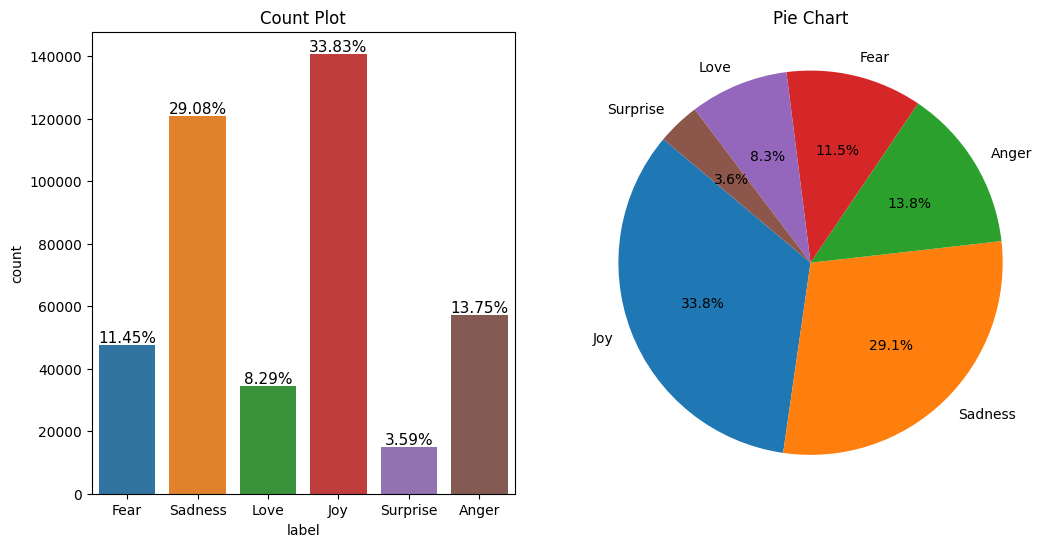

In [15]:
# Calculate percentages
total = len(emotions_df)
percentage_data = emotions_df['label'].value_counts(normalize=True) * 100

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
sns.countplot(x='label', data=emotions_df, ax=axs[0])
axs[0].set_title('Count Plot')

# Add percentages on top of each bar in bar plot
for p in axs[0].patches:
    axs[0].annotate(f'{p.get_height()/len(emotions_df)*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Pie chart
axs[1].pie(percentage_data, labels=percentage_data.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Pie Chart')

# Equal aspect ratio ensures that pie is drawn as a circle
axs[1].axis('equal')

plt.show()

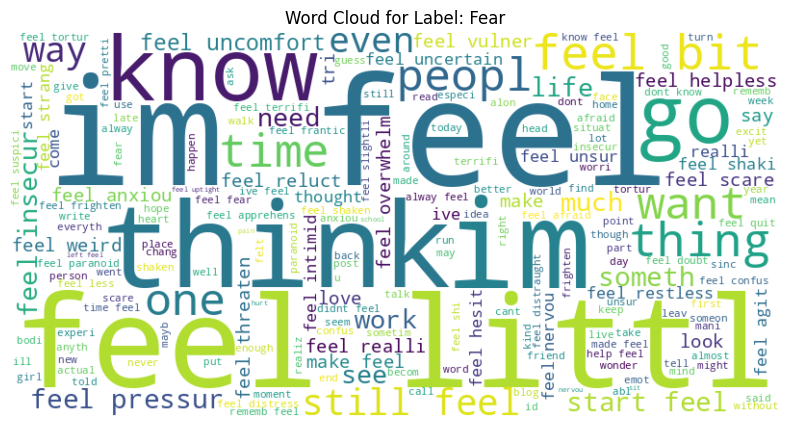

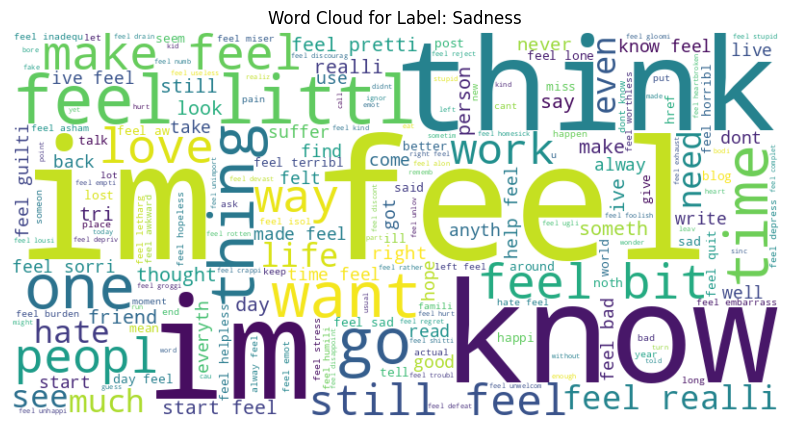

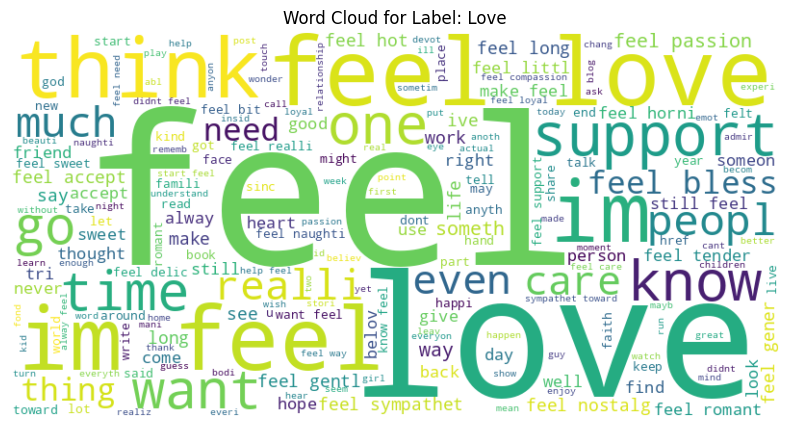

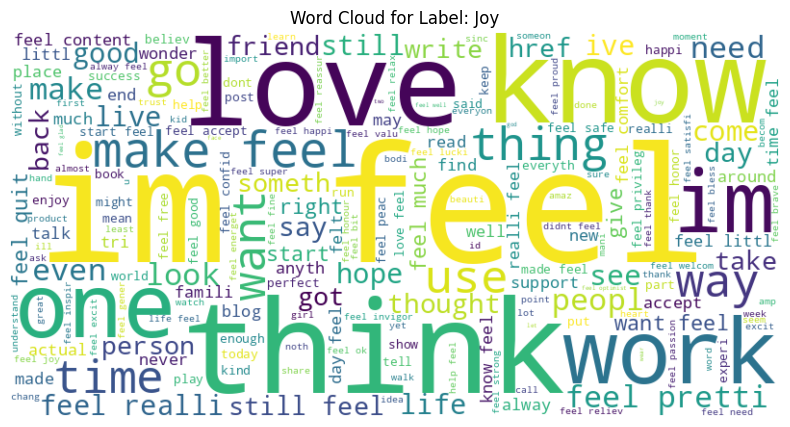

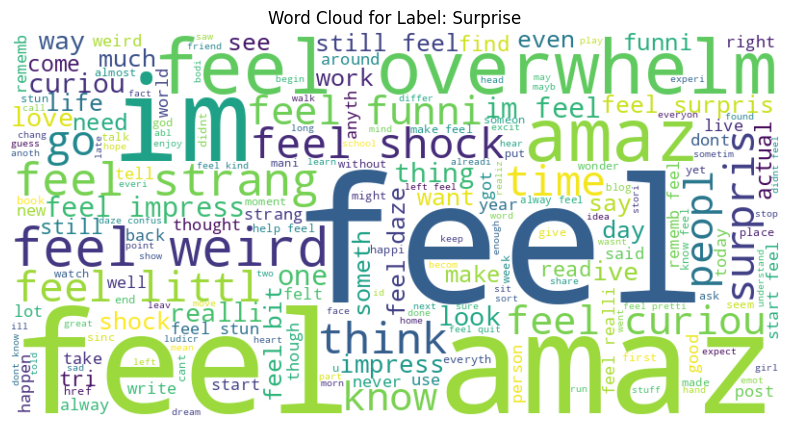

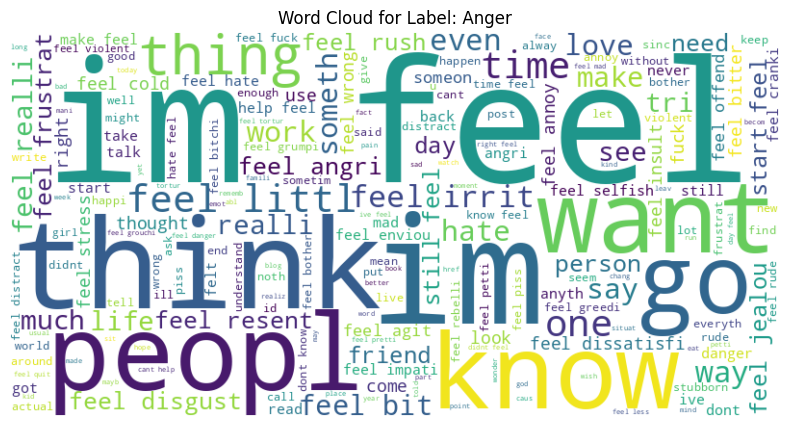

In [16]:
# Iterate through unique labels
for label in emotions_df['label'].unique():
    # Filter the DataFrame for the current label
    filtered_df = emotions_df[emotions_df['label'] == label].copy()
    
    filtered_df.loc[:,'msg_tokenied_wo_stopwords_stemmed_str'] = filtered_df['msg_tokenied_wo_stopwords_stemmed'].apply(lambda x : " ".join(x))
    
    # Concatenate all text data for the current label
    text = ' '.join(filtered_df['msg_tokenied_wo_stopwords_stemmed_str'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

Observations : "im" and "feel" appears in all the emotions.

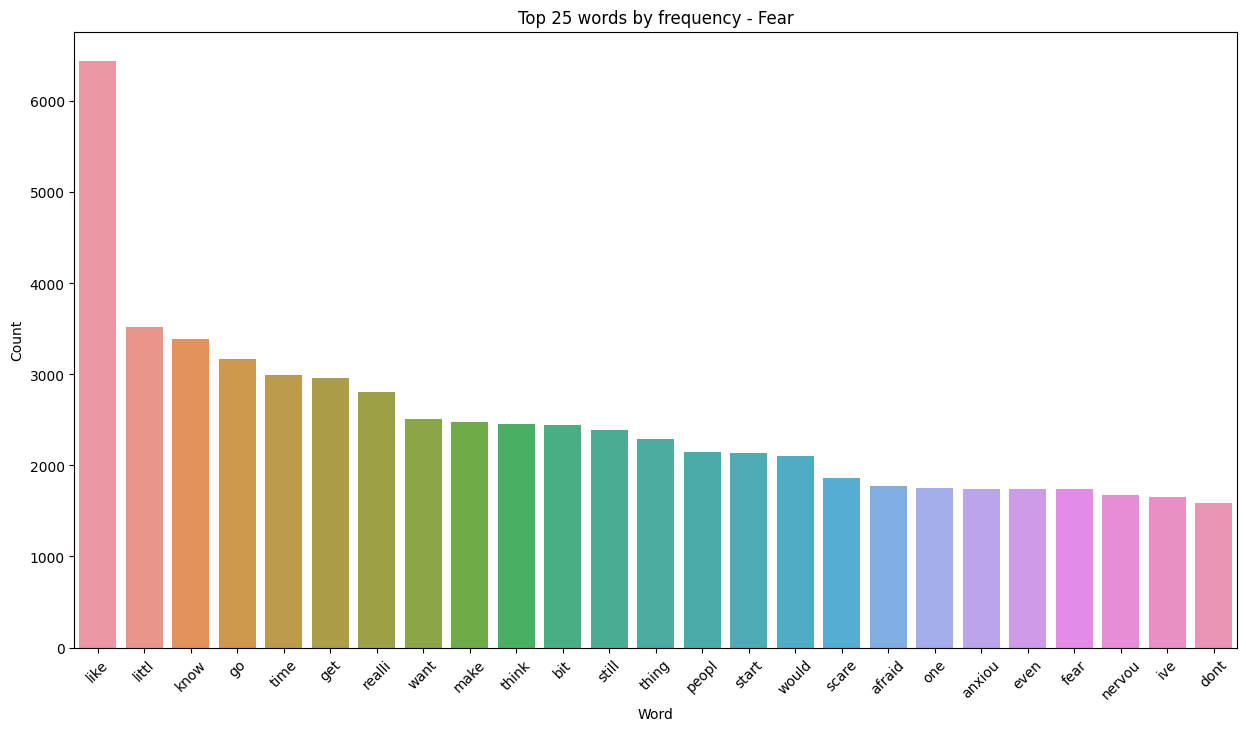

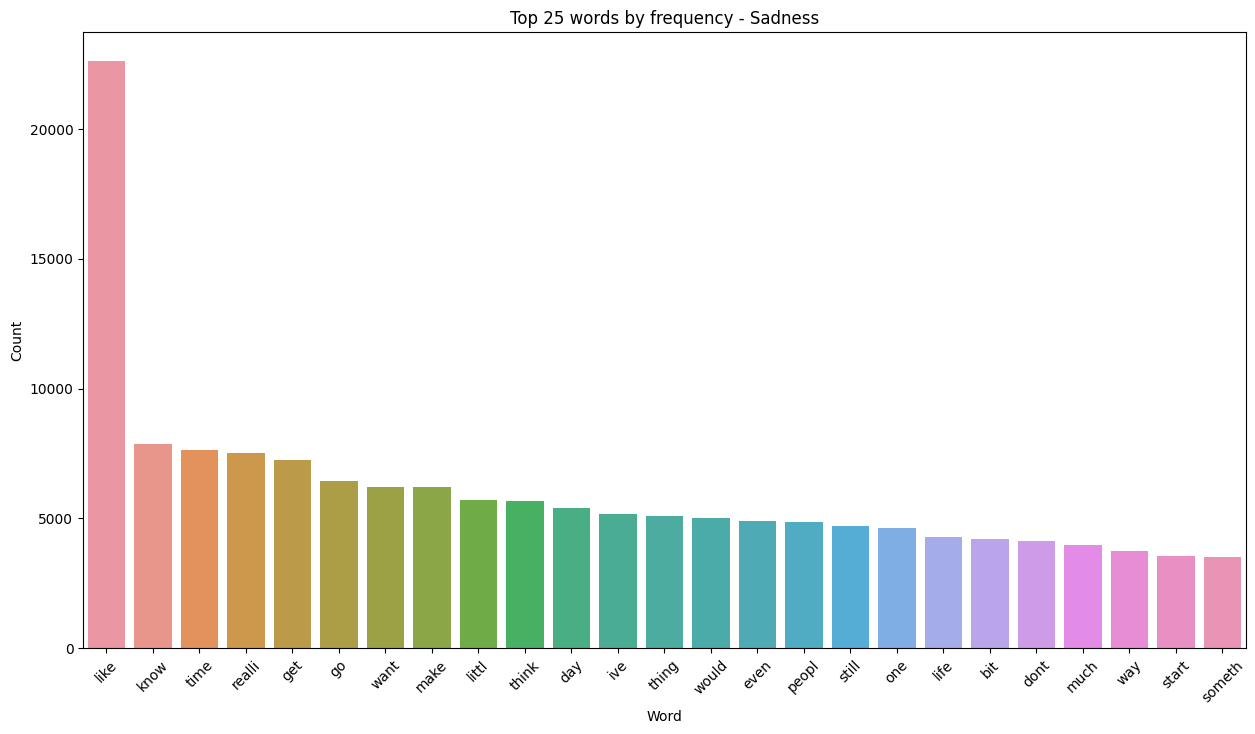

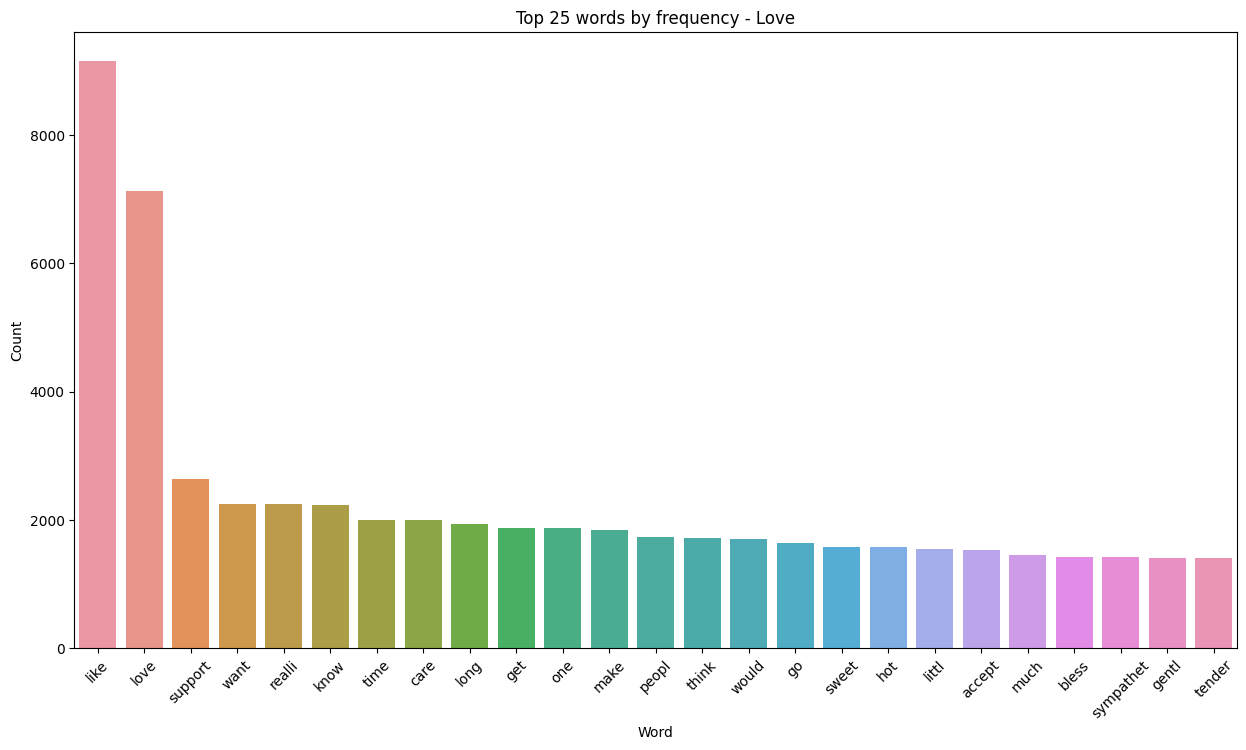

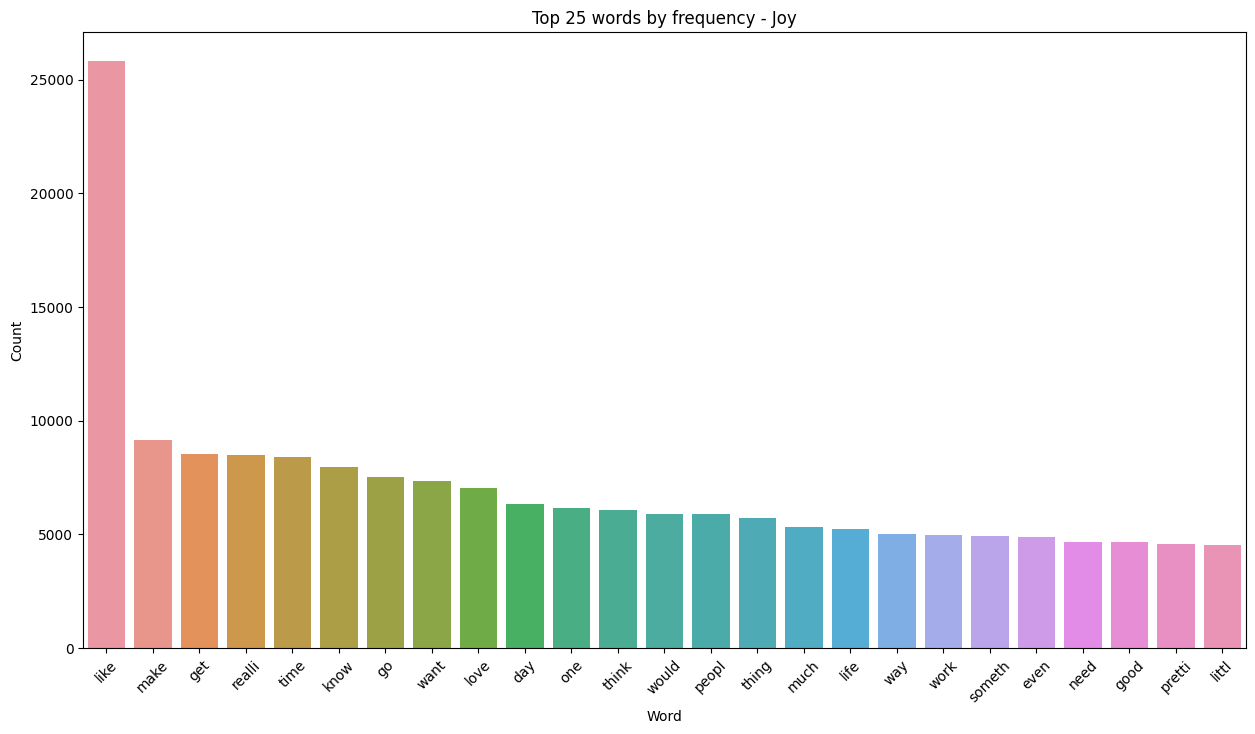

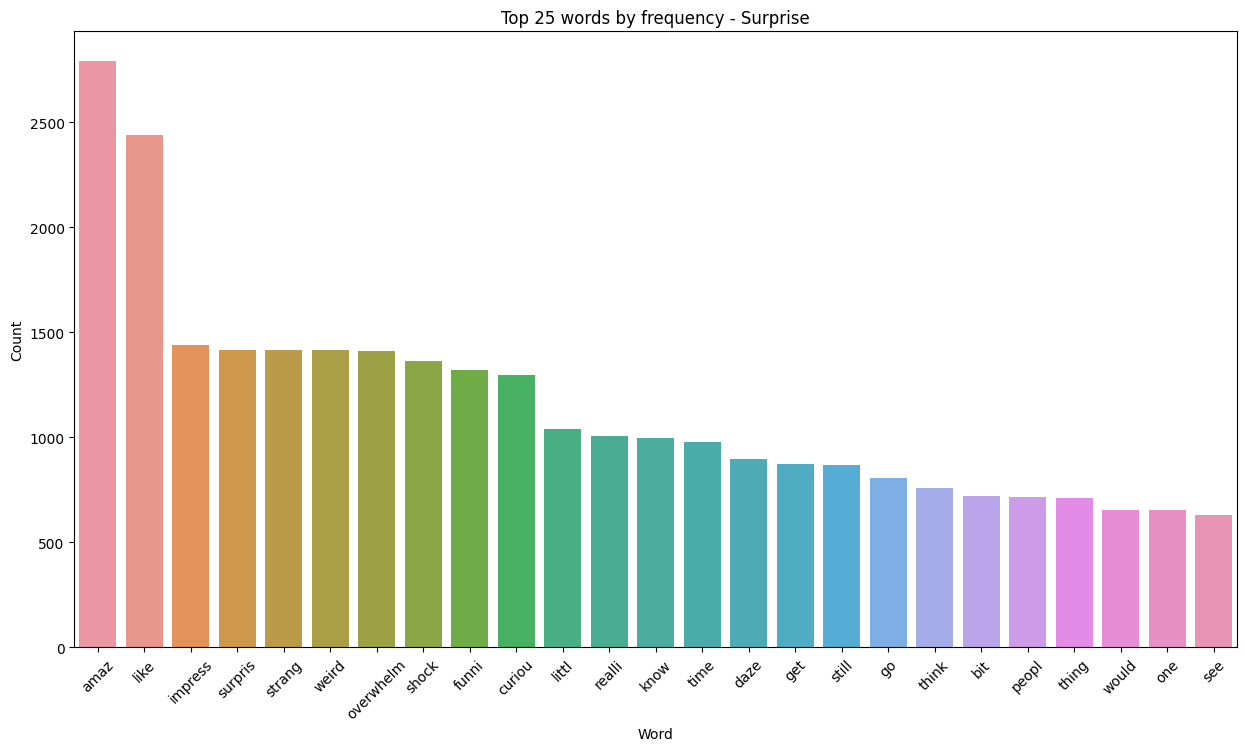

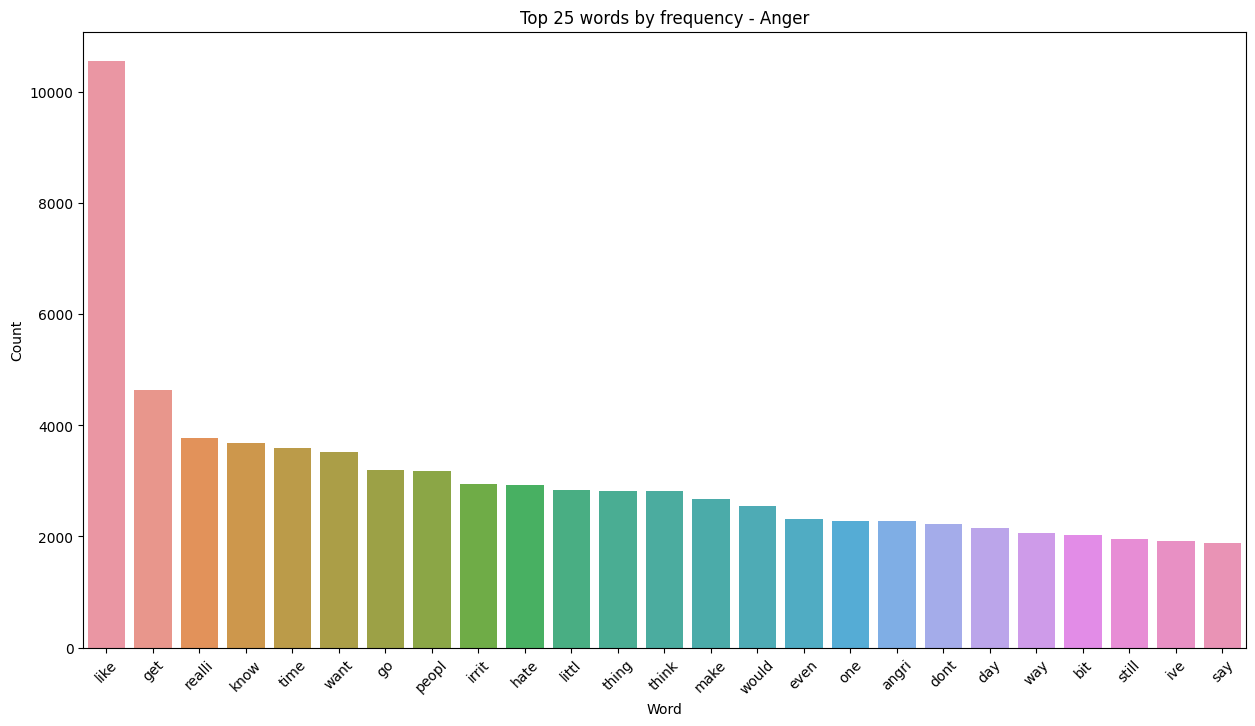

In [17]:
# Get most used words at each sentiment
for emotion in emotions_df.label.unique():
    senti_grp_df = emotions_df[emotions_df.label == emotion]
    senti_grp_vocab =  list(chain.from_iterable(senti_grp_df.msg_tokenied_wo_stopwords_stemmed.to_list())) 
    senti_grp_vocab_count_df = pd.DataFrame({"Word" : list(dict(Counter(senti_grp_vocab)).keys()), "Count" : list(dict(Counter(senti_grp_vocab)).values())})
    
    senti_grp_vocab_count_df = senti_grp_vocab_count_df[~senti_grp_vocab_count_df['Word'].isin(['im', 'feel'])].copy()
    
    senti_grp_vocab_count_df = senti_grp_vocab_count_df.sort_values(by=["Count"],ascending = False)
    
    plt.figure(figsize=(15,8))
    sns.barplot(data = senti_grp_vocab_count_df.iloc[:25,],x="Word",y="Count")
    
    plt.title("Top 25 words by frequency - " + emotion)
    plt.xticks(rotation=45)
    plt.show()

In [18]:
vec = CountVectorizer().fit(emotions_df['text'])
bag_of_words = vec.transform(emotions_df['text'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

In [19]:
emotions_df['final_text'] = emotions_df.msg_tokenied_wo_stopwords_stemmed.apply(lambda x: ' '.join(x))
emotions_df

,text,label,cleaned_text,msg_tokenied,msg_tokenied_wo_stopwords,msg_tokenied_wo_stopwords_stemmed,word_count,final_text
0,i just feel really helpless and heavy hearted,Fear,i just feel really helpless and heavy hearted,"[i, just, feel, really, helpless, and, heavy, ...","[feel, really, helpless, heavy, hearted]","[feel, realli, helpless, heavi, heart]",5,feel realli helpless heavi heart
1,ive enjoyed being able to slouch about relax a...,Sadness,ive enjoyed being able to slouch about relax a...,"[ive, enjoyed, being, able, to, slouch, about,...","[ive, enjoyed, able, slouch, relax, unwind, fr...","[ive, enjoy, abl, slouch, relax, unwind, frank...",24,ive enjoy abl slouch relax unwind frankli need...
2,i gave up my internship with the dmrg and am f...,Fear,i gave up my internship with the dmrg and am f...,"[i, gave, up, my, internship, with, the, dmrg,...","[gave, internship, dmrg, feeling, distraught]","[gave, internship, dmrg, feel, distraught]",5,gave internship dmrg feel distraught
3,i dont know i feel so lost,Sadness,i dont know i feel so lost,"[i, dont, know, i, feel, so, lost]","[dont, know, feel, lost]","[dont, know, feel, lost]",4,dont know feel lost
4,i am a kindergarten teacher and i am thoroughl...,Fear,i am a kindergarten teacher and i am thoroughl...,"[i, am, a, kindergarten, teacher, and, i, am, ...","[kindergarten, teacher, thoroughly, weary, job...","[kindergarten, teacher, thoroughli, weari, job...",17,kindergarten teacher thoroughli weari job take...
...,...,...,...,...,...,...,...,...
416804,i feel like telling these horny devils to find...,Love,i feel like telling these horny devils to find...,"[i, feel, like, telling, these, horny, devils,...","[feel, like, telling, horny, devils, find, sit...","[feel, like, tell, horni, devil, find, site, s...",14,feel like tell horni devil find site suit sort...
416805,i began to realize that when i was feeling agi...,Anger,i began to realize that when i was feeling agi...,"[i, began, to, realize, that, when, i, was, fe...","[began, realize, feeling, agitated, restless, ...","[began, realiz, feel, agit, restless, would, t...",9,began realiz feel agit restless would thought ...
416806,i feel very curious be why previous early dawn...,Surprise,i feel very curious be why previous early dawn...,"[i, feel, very, curious, be, why, previous, ea...","[feel, curious, previous, early, dawn, time, s...","[feel, curiou, previou, earli, dawn, time, see...",8,feel curiou previou earli dawn time seek troubl
416807,i feel that becuase of the tyranical nature of...,Anger,i feel that becuase of the tyranical nature of...,"[i, feel, that, becuase, of, the, tyranical, n...","[feel, becuase, tyranical, nature, government,...","[feel, becuas, tyran, natur, govern, el, salva...",22,feel becuas tyran natur govern el salvador sav...


In [20]:
X_train, X_test, y_train, y_test = train_test_split(emotions_df.final_text, emotions_df.label, test_size=0.33, random_state=42)

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X_train_trans = tfidf_vectorizer.fit_transform(X_train)
X_test_trans = tfidf_vectorizer.transform(X_test)

In [22]:
tSVD = TruncatedSVD(n_components=20)
tSVD.fit(X_train_trans)

X_train_trans_decom = tSVD.transform(X_train_trans)
X_test_trans_decom = tSVD.transform(X_test_trans)

In [23]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_trans_decom, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred = clf.predict(X_test_trans_decom)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Anger       0.44      0.20      0.27     19027
        Fear       0.37      0.16      0.22     15775
         Joy       0.50      0.70      0.58     46386
        Love       0.31      0.15      0.20     11357
     Sadness       0.45      0.56      0.50     39794
    Surprise       0.18      0.06      0.08      4982

    accuracy                           0.46    137321
   macro avg       0.37      0.30      0.31    137321
weighted avg       0.43      0.46      0.42    137321

